In [1]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.4 MB/s eta 0:00:00


In [24]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


In [25]:
import kagglehub
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Path to dataset files:", path)
data_root = os.path.join(path, "garbage classification", "Garbage classification")
print("Class folders:", os.listdir(data_root))


Path to dataset files: /kaggle/input/garbage-classification
Class folders: ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [26]:
import shutil
import random

# YOLO dataset structure
yolo_root = "waste_yolo_dataset"
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(yolo_root, "images", split), exist_ok=True)
    os.makedirs(os.path.join(yolo_root, "labels", split), exist_ok=True)

# Class mapping
classes = sorted(os.listdir(data_root))
class_map = {cls: i for i, cls in enumerate(classes)}
print("Class mapping:", class_map)

# Split ratios
train_ratio, val_ratio = 0.7, 0.2
for cls in classes:
    cls_dir = os.path.join(data_root, cls)
    images = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(images)
    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train+n_val],
        "test": images[n_train+n_val:]
    }

    for split, files in splits.items():
        for img_path in files:
            img_name = os.path.basename(img_path)
            dst_img = os.path.join(yolo_root, "images", split, img_name)
            shutil.copy(img_path, dst_img)

            # Create dummy YOLO label (whole image is class)
            label_name = img_name.rsplit(".", 1)[0] + ".txt"
            dst_label = os.path.join(yolo_root, "labels", split, label_name)
            with open(dst_label, "w") as f:
                cls_id = class_map[cls]
                f.write(f"{cls_id} 0.5 0.5 1.0 1.0\n")


Class mapping: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [27]:
yaml_content = f"""
path: {yolo_root}
train: images/train
val: images/val
test: images/test

names:
"""

for i, cls in enumerate(classes):
    yaml_content += f"  {i}: {cls}\n"
with open("waste_data.yaml", "w") as f:
    f.write(yaml_content)
print("data.yaml created")


data.yaml created


In [28]:
from ultralytics import YOLO

model = YOLO("yolov8n.yaml")
model.train(
    data="waste_data.yaml",
    epochs=10,
    imgsz=224,
    batch=16
)


Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=waste_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7975615b9d30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [29]:
results = model.predict(
    source=os.path.join(yolo_root, "images/test"),
    conf=0.25,
    save=True,
    save_txt=True
)



image 1/612 /content/waste_yolo_dataset/images/test/cardboard11.jpg: 192x224 1 cardboard, 6.9ms
image 2/612 /content/waste_yolo_dataset/images/test/cardboard111.jpg: 192x224 1 cardboard, 6.0ms
image 3/612 /content/waste_yolo_dataset/images/test/cardboard112.jpg: 192x224 (no detections), 7.5ms
image 4/612 /content/waste_yolo_dataset/images/test/cardboard124.jpg: 192x224 1 paper, 6.4ms
image 5/612 /content/waste_yolo_dataset/images/test/cardboard128.jpg: 192x224 1 paper, 6.1ms
image 6/612 /content/waste_yolo_dataset/images/test/cardboard129.jpg: 192x224 1 paper, 5.8ms
image 7/612 /content/waste_yolo_dataset/images/test/cardboard132.jpg: 192x224 1 paper, 6.0ms
image 8/612 /content/waste_yolo_dataset/images/test/cardboard133.jpg: 192x224 1 cardboard, 5.7ms
image 9/612 /content/waste_yolo_dataset/images/test/cardboard135.jpg: 192x224 1 paper, 5.7ms
image 10/612 /content/waste_yolo_dataset/images/test/cardboard138.jpg: 192x224 1 cardboard, 5.7ms
image 11/612 /content/waste_yolo_dataset/imag

Latest prediction folder: runs/detect/train72
Found 612 predicted images.


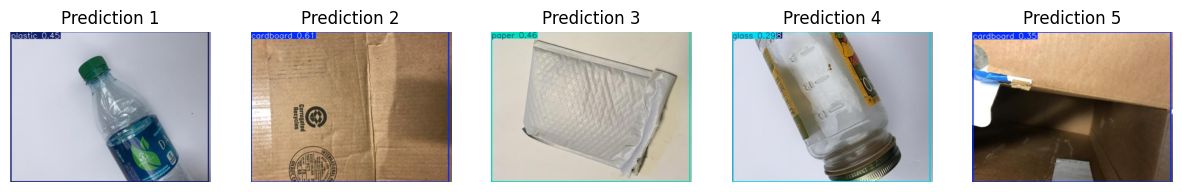

In [30]:
subdirs = [d for d in glob.glob("runs/detect/*") if os.path.isdir(d)]
if not subdirs:
    raise ValueError("No YOLO prediction folders found. Did inference run?")
latest_run = max(subdirs, key=os.path.getmtime)
print("Latest prediction folder:", latest_run)
# Collect prediction images
pred_images = glob.glob(os.path.join(latest_run, "*.jpg"))
print("Found", len(pred_images), "predicted images.")
n = min(5, len(pred_images))
plt.figure(figsize=(15, 10))

for i in range(n):
    img = cv2.imread(pred_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction {i+1}")

plt.show()
